In [1]:
import pandas as pd
import importlib
import sys
from tqdm import tqdm
import time
import geopandas as gpd
import numpy as np
from shapely.geometry import Polygon, Point
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.collections import LineCollection
import contextily as cx
from datetime import datetime, timedelta
from scipy.signal import butter,filtfilt

In [2]:
from readers.InSAR import InSAR
from readers.GNSS import GNSS

In [3]:
insar = InSAR('data/time_series_Saarland_Orbit139_update.nc')
master_day = insar.get_master_day() # I think that we should completely discard gnss stations that do not have the reference day
insar_df = insar.get_df()
gnss = GNSS('data/selected_stations_dates.csv', master_day)
gnss_df = gnss.get_df()

Computing zscores and removing outliers for InSAR...


100%|██████████| 218637/218637 [01:09<00:00, 3135.30it/s]
/cluster/home/jlucki/DSL/insar-super-resolution/readers/GNSS.py:94: UserWarning: BIWI does not have data for 6625. Using closest day 6624 instead.
/cluster/home/jlucki/DSL/insar-super-resolution/readers/GNSS.py:94: UserWarning: D525 does not have data for 6625. Using closest day 5920 instead.
/cluster/home/jlucki/DSL/insar-super-resolution/readers/GNSS.py:94: UserWarning: LUX1 does not have data for 6625. Using closest day 6820 instead.
/cluster/home/jlucki/DSL/insar-super-resolution/readers/GNSS.py:94: UserWarning: MOLV does not have data for 6625. Using closest day 6624 instead.
/cluster/home/jlucki/DSL/insar-super-resolution/readers/GNSS.py:94: UserWarning: MOUS does not have data for 6625. Using closest day 6624 instead.
/cluster/home/jlucki/DSL/insar-super-resolution/readers/GNSS.py:94: UserWarning: OBER does not have data for 6625. Using closest day 6624 instead.
/cluster/home/jlucki/DSL/insar-super-resolution/readers/GNSS

### Plot vertical displacement and position on the map

In [4]:
# We will focus on a particular site
site_name = "DILL"
site_df = gnss_df[gnss_df["site"] == site_name]
site_gdf = gnss.get_sites_gdf().loc[site_name]
site_lat = site_gdf["_latitude(deg)"]
site_long = site_gdf["_longitude(deg)"]

In [5]:
# and a particular k
k = 5
selected_insar = insar.get_k_closest_points(site_long, site_lat, k = k) # takes ~30sec

Searching for 5 nearest InSAR datapoints


100%|██████████| 218637/218637 [00:38<00:00, 5716.54it/s]


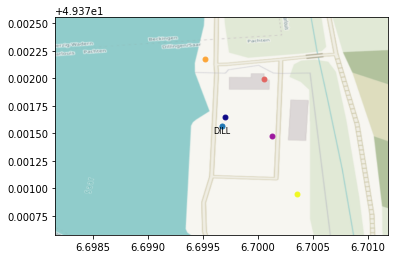

In [6]:
ax = plt.gca()
# plot gnss station
bbox = gnss.get_bbox_around_site(site_name)
gpd.GeoSeries(bbox).plot(ax=ax, color='green', alpha=0) #this is just to make image show everything within bounds
gpd.GeoSeries(site_gdf.geometry).plot(ax=ax, markersize=25)
ax.text(site_gdf.geometry.x,
        site_gdf.geometry.y,
        site_gdf.name,
        fontsize=8, ha='center', va='top')
# plot k nearest insar points
cmap = mpl.colormaps['plasma']
d = selected_insar["distance(m)"]
d = (d - d.min())/(d.max()-d.min())
for i in range(k):
    row = selected_insar.iloc[i,:]
    gpd.GeoSeries(Point(row["longitude"], row["latitude"])).plot(ax=ax, markersize=24, color=cmap(d.iloc[i]))
cx.add_basemap(ax=ax, crs = 'EPSG:4326', attribution='')

In [7]:
def multiline(xs, ys, c, ax=None, **kwargs):
    """Plot lines with different colorings
    
    https://stackoverflow.com/questions/38208700/matplotlib-plot-lines-with-colors-through-colormap

    Parameters
    ----------
    xs : iterable container of x coordinates
    ys : iterable container of y coordinates
    c : iterable container of numbers mapped to colormap
    ax (optional): Axes to plot on.
    kwargs (optional): passed to LineCollection

    Notes:
        len(xs) == len(ys) == len(c) is the number of line segments
        len(xs[i]) == len(ys[i]) is the number of points for each line (indexed by i)

    Returns
    -------
    lc : LineCollection instance.
    """

    # find axes
    ax = plt.gca() if ax is None else ax

    # create LineCollection
    segments = [np.column_stack([x, y]) for x, y in zip(xs, ys)]
    lc = LineCollection(segments, **kwargs)

    # set coloring of line segments
    #    Note: I get an error if I pass c as a list here... not sure why.
    lc.set_array(np.asarray(c))

    # add lines to axes and rescale 
    #    Note: adding a collection doesn't autoscalee xlim/ylim
    ax.add_collection(lc)
    ax.autoscale()
    return lc

def plot_gnss_with_insar_points(selected_insar, selected_insar_distances, site_df, value_to_show = 'st_up_no_year(mm)', gnss_only_matching_days = False, ax = None):
    # Get site data
    site_name = site_df["site"].iloc[0]
    # Get insar data
    insar_days = [int(col[-4:]) for col in selected_insar.columns if col.startswith("day")]
    selected_insar_data = selected_insar[[col for col in selected_insar.columns if col.startswith("day")]]
    assert len(selected_insar_data.columns) == 112
    
    # Get gnss data
    if gnss_only_matching_days:
        selected_gnss_data = site_df[site_df['day'].isin(insar_days)]
        gnss_days = selected_gnss_data["day"].values
        selected_gnss_data = selected_gnss_data[value_to_show]
    else:
        selected_gnss_data = site_df[value_to_show]
        gnss_days = site_df["day"]
        
    # Make axis and figure if there are none
    ax = plt.gca() if ax is None else ax
    fig = plt.gcf()
        
    # Plot data
    fig.set_figwidth(20)
    lc = multiline([insar_days]*5, selected_insar_data.values, selected_insar_distances, cmap='plasma', lw=1.5)
    axcb = fig.colorbar(lc)
    ax.plot(gnss_days, selected_gnss_data, lw=1.5, c="green", alpha= 0.6,label = f"GNSS_{site_name}") # without outlier removal gnss reaches 140 at some point
    axcb.set_label(f'Distance from {site_name} in meters')
    ax.set_title(f'{k} closest InSar data points to {site_name}')
    ax.set_ylabel("Vertical displacement in mm")
    ax.set_xlabel("Days of measurements")
    ax.legend()
    
    fig.tight_layout()

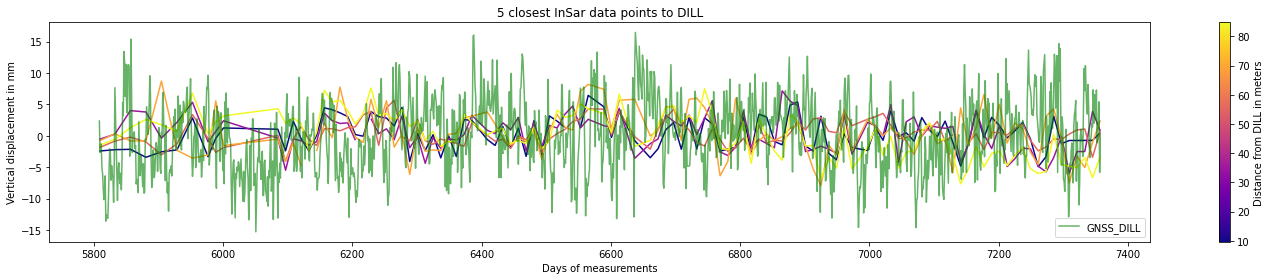

In [8]:
plot_gnss_with_insar_points(selected_insar,selected_insar["distance(m)"], site_df)

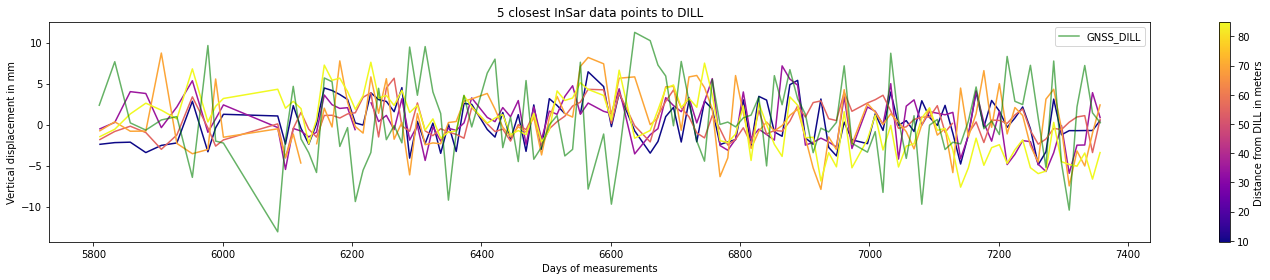

In [9]:
plot_gnss_with_insar_points(selected_insar, selected_insar["distance(m)"],site_df, gnss_only_matching_days = True)

### Low pass filter

1.6534391534391535e-07
Filtering InSAR signal...
Using provided dataset


100%|██████████| 5/5 [00:00<00:00, 1489.35it/s]


8.267195767195767e-08
Filtering InSAR signal...
Using provided dataset


100%|██████████| 5/5 [00:00<00:00, 1668.91it/s]


4.1335978835978836e-08
Filtering InSAR signal...
Using provided dataset


100%|██████████| 5/5 [00:00<00:00, 1680.14it/s]


2.0667989417989418e-08
Filtering InSAR signal...
Using provided dataset


100%|██████████| 5/5 [00:00<00:00, 1672.10it/s]


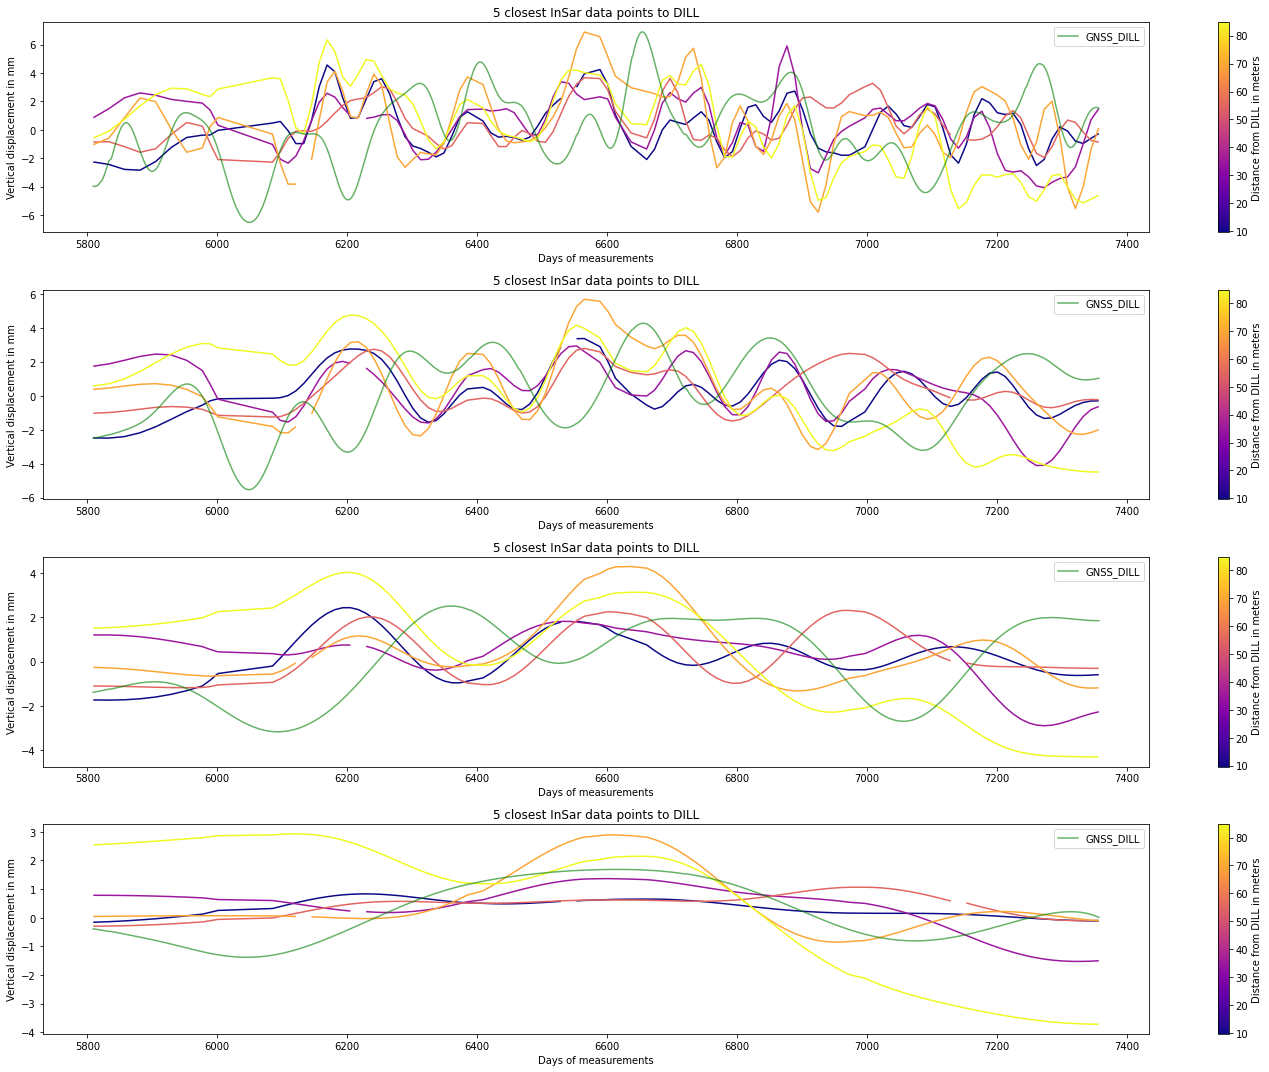

In [10]:
plt.figure(figsize=(15, 15))
fs = insar.sampling_freq
cutoffs = [fs/5, fs/10, fs/20, fs/40]

for i, cutoff in enumerate(cutoffs):
    plt.subplot(len(cutoffs), 1,i+1)
    print(cutoff)
    filtered_insar = insar.filter_signal(cutoff,selected_insar)
    filtered_gnss = gnss.filter_signal(cutoff, site_name, cache = False)
    plot_gnss_with_insar_points(filtered_insar,selected_insar["distance(m)"], filtered_gnss, value_to_show = "st_up_filtered(mm)")
    plt.margins()

### Derivative kernel

In [11]:
freq = insar.sampling_freq/5

filtered_insar = insar.filter_signal(freq, selected_insar)
derived_insar = insar.take_derivative(dataset =filtered_insar)

filtered_gnss = gnss.filter_signal(freq, site_name, cache = False)
derived_gnss = gnss.take_derivative(site_name, cache = False)

Filtering InSAR signal...
Using provided dataset


100%|██████████| 5/5 [00:00<00:00, 1608.25it/s]


Taking derivative of InSAR signal...
Using provided dataset


100%|██████████| 5/5 [00:00<00:00, 7296.98it/s]


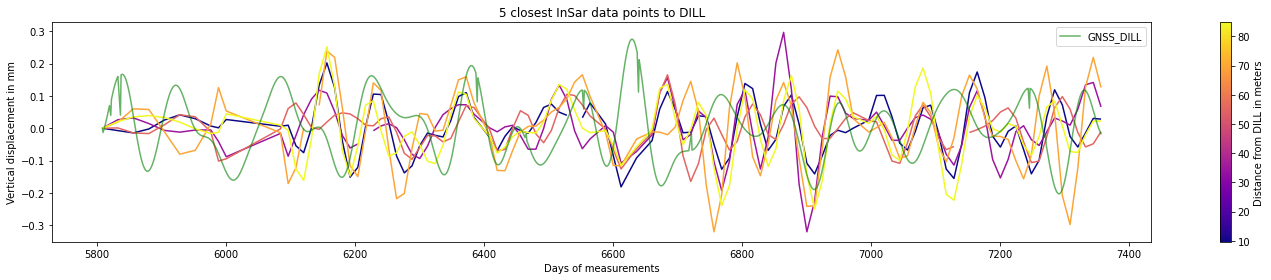

In [12]:
plot_gnss_with_insar_points(derived_insar,selected_insar["distance(m)"], derived_gnss, value_to_show = "st_up_derivative(mm)")